# HW06: Деревья решений и ансамбли

## Задание

Цель: закрепить понимание деревьев решений и ансамблевых методов (bagging, random forest, boosting, stacking), а также провести честный ML-эксперимент.

In [2]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

# Фиксируем случайный.seed для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2.3.1. Загрузка данных и первичный анализ

In [3]:
# Загрузка данных
# Выберите один из датасетов: S06-hw-dataset-01.csv, S06-hw-dataset-02.csv, S06-hw-dataset-03.csv, S06-hw-dataset-04.csv
df = pd.read_csv('S06-hw-dataset-02.csv')  # Измените на нужный датасет

# Просмотр данных
print("Форма данных:", df.shape)
print("\nПервые строки:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

print("\nСтатистики:")
print(df.describe())

# Распределение таргета
print("\nРаспределение таргета:")
print(df['target'].value_counts(normalize=True))

Форма данных: (18000, 39)

Первые строки:
   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087 

In [4]:
# Проверка пропусков и типов столбцов
print("Пропущенные значения:")
print(df.isnull().sum())

print("\nТипы столбцов:")
print(df.dtypes)

# Определение X и y
# Предполагаем, что столбец 'id' не используется как признак
if 'id' in df.columns:
    X = df.drop(['target', 'id'], axis=1)
else:
    X = df.drop(['target'], axis=1)
    
y = df['target']

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")

Пропущенные значения:
id         0
f01        0
f02        0
f03        0
f04        0
f05        0
f06        0
f07        0
f08        0
f09        0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
f27        0
f28        0
f29        0
f30        0
f31        0
f32        0
f33        0
f34        0
f35        0
x_int_1    0
x_int_2    0
target     0
dtype: int64

Типы столбцов:
id           int64
f01        float64
f02        float64
f03        float64
f04        float64
f05        float64
f06        float64
f07        float64
f08        float64
f09        float64
f10        float64
f11        float64
f12        float64
f13        float64
f14        float64
f15        float64
f16        float64
f17        float64
f18        float64
f19        float64
f20        float64
f21        float64
f22        float64
f23  

## 2.3.2. Train/Test-сплит и воспроизводимость

In [5]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y  # Для классификации используем стратификацию
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Доли классов в train: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Доли классов в test: {y_test.value_counts(normalize=True).to_dict()}")

# Пояснение важности фиксированного seed и стратификации
print("\nФиксированный seed обеспечивает воспроизводимость результатов.")
print("Стратификация сохраняет пропорции классов в train и test, что важно для корректной оценки модели.")

Размер обучающей выборки: 14400
Размер тестовой выборки: 3600
Доли классов в train: {0: 0.7373611111111111, 1: 0.26263888888888887}
Доли классов в test: {0: 0.7375, 1: 0.2625}

Фиксированный seed обеспечивает воспроизводимость результатов.
Стратификация сохраняет пропорции классов в train и test, что важно для корректной оценки модели.


## 2.3.3. Baseline'ы

In [6]:
# Baseline 1: DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print("Baseline 1 - DummyClassifier (most_frequent strategy):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dummy, average='macro'):.4f}")
if len(np.unique(y)) == 2:  # Если бинарная классификация
    print(f"ROC-AUC: {roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1]):.4f}")

# Baseline 2: Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("\nBaseline 2 - Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='macro'):.4f}")
if len(np.unique(y)) == 2:  # Если бинарная классификация
    y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

Baseline 1 - DummyClassifier (most_frequent strategy):
Accuracy: 0.7375
F1 Score: 0.4245
ROC-AUC: 0.5000

Baseline 2 - Logistic Regression:
Accuracy: 0.8119
F1 Score: 0.7205
ROC-AUC: 0.7977


## 2.3.4. Модели недели 6

In [7]:
# Модель 1: Decision Tree с контролем сложности
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_params,
    cv=5,
    scoring='roc_auc' if len(np.unique(y)) == 2 else 'f1_macro',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)
if len(np.unique(y)) == 2:
    y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]
    dt_roc_auc = roc_auc_score(y_test, y_pred_proba_dt)
else:
    dt_roc_auc = None

print("Decision Tree (best params):", dt_grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt, average='macro'):.4f}")
if dt_roc_auc is not None:
    print(f"ROC-AUC: {dt_roc_auc:.4f}")

Decision Tree (best params): {'max_depth': 10, 'min_samples_leaf': 20}
Accuracy: 0.8336
F1 Score: 0.7711
ROC-AUC: 0.8374


In [8]:
# Модель 2: Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    rf_params,
    cv=5,
    scoring='roc_auc' if len(np.unique(y)) == 2 else 'f1_macro',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
if len(np.unique(y)) == 2:
    y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
    rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
else:
    rf_roc_auc = None

print("Random Forest (best params):", rf_grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
if rf_roc_auc is not None:
    print(f"ROC-AUC: {rf_roc_auc:.4f}")

Random Forest (best params): {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Accuracy: 0.8872
F1 Score: 0.8372
ROC-AUC: 0.9246


In [9]:
# Модель 3: Boosting (Gradient Boosting)
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    gb_params,
    cv=5,
    scoring='roc_auc' if len(np.unique(y)) == 2 else 'f1_macro',
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test)
if len(np.unique(y)) == 2:
    y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]
    gb_roc_auc = roc_auc_score(y_test, y_pred_proba_gb)
else:
    gb_roc_auc = None

print("Gradient Boosting (best params):", gb_grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_gb, average='macro'):.4f}")
if gb_roc_auc is not None:
    print(f"ROC-AUC: {gb_roc_auc:.4f}")

Gradient Boosting (best params): {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.8942
F1 Score: 0.8558
ROC-AUC: 0.9255


In [10]:
# Модель 4: Stacking (опционально)
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)),
    ('lr', Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))]))
]

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5  # Кросс-валидация для получения прогнозов базовых моделей
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

if len(np.unique(y)) == 2:
    y_pred_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]
    stack_roc_auc = roc_auc_score(y_test, y_pred_proba_stack)
else:
    stack_roc_auc = None

print("Stacking Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_stack, average='macro'):.4f}")
if stack_roc_auc is not None:
    print(f"ROC-AUC: {stack_roc_auc:.4f}")

Stacking Classifier:
Accuracy: 0.8228
F1 Score: 0.7397
ROC-AUC: 0.8203


## 2.3.5. Метрики качества

In [11]:
# Сравнение всех моделей по всем метрикам
models_results = {}

# Словарь моделей
all_models = {
    'Dummy': (dummy_clf, y_pred_dummy, None if len(np.unique(y)) != 2 else dummy_clf.predict_proba(X_test)[:, 1]),
    'Logistic_Regression': (lr_pipeline, y_pred_lr, y_pred_proba_lr if len(np.unique(y)) == 2 else None),
    'Decision_Tree': (best_dt, y_pred_dt, y_pred_proba_dt if len(np.unique(y)) == 2 else None),
    'Random_Forest': (best_rf, y_pred_rf, y_pred_proba_rf if len(np.unique(y)) == 2 else None),
    'Gradient_Boosting': (best_gb, y_pred_gb, y_pred_proba_gb if len(np.unique(y)) == 2 else None),
    'Stacking': (stacking_clf, y_pred_stack, y_pred_proba_stack if len(np.unique(y)) == 2 else None)
}

# Вычисляем метрики для всех моделей
for name, (model, y_pred, y_proba) in all_models.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    models_results[name] = {
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Вывод таблицы результатов
results_df = pd.DataFrame(models_results).T
print(results_df)

                     accuracy  f1_score   roc_auc
Dummy                0.737500  0.424460  0.500000
Logistic_Regression  0.811944  0.720521  0.797691
Decision_Tree        0.833611  0.771127  0.837352
Random_Forest        0.887222  0.837165  0.924603
Gradient_Boosting    0.894167  0.855796  0.925488
Stacking             0.822778  0.739676  0.820299


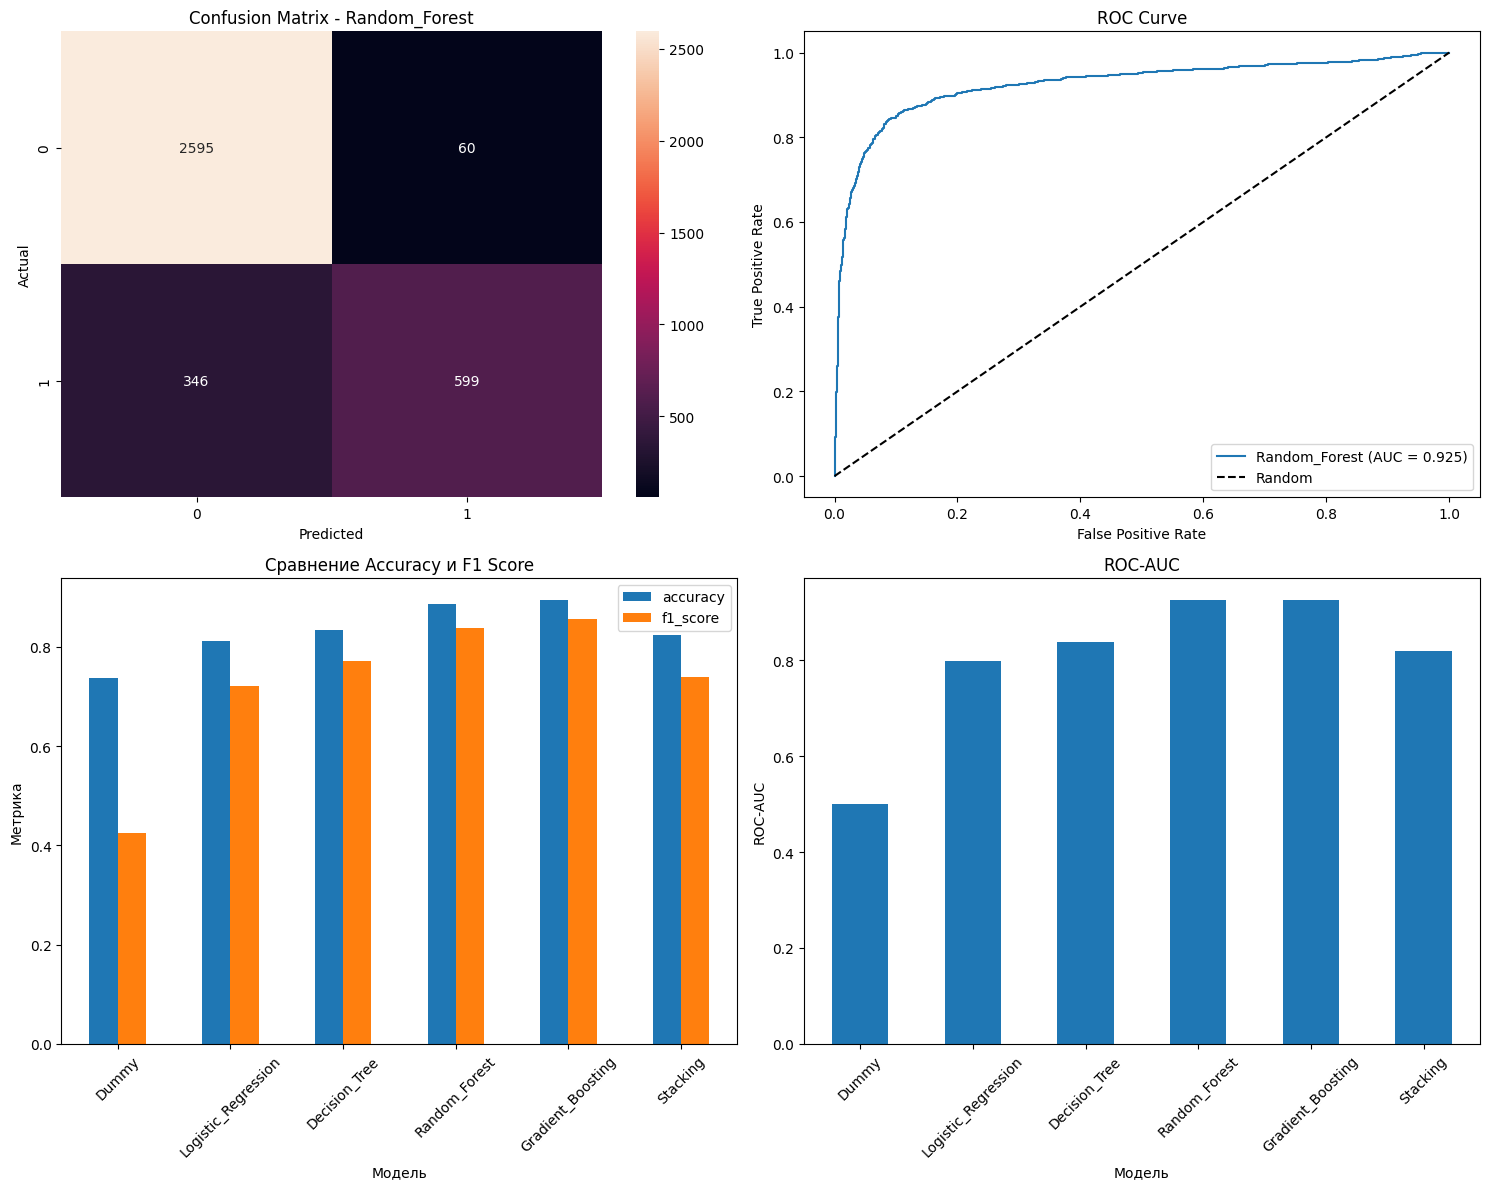

In [12]:
# Графики
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix для лучшей модели (предположим, это Random Forest)
best_model_name = 'Random_Forest'  # Можно определить программно какую модель выбрать как лучшую
best_y_pred = all_models[best_model_name][1]

cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve для бинарной классификации
if len(np.unique(y)) == 2:
    from sklearn.metrics import roc_curve
    
    fpr, tpr, _ = roc_curve(y_test, all_models[best_model_name][2])
    axes[0,1].plot(fpr, tpr, label=f'{best_model_name} (AUC = {models_results[best_model_name]["roc_auc"]:.3f})')
    axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, 'ROC-AUC не применима\\nк мультиклассу', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('ROC Curve (not applicable for multiclass)')

# Сравнение метрик
metrics_comparison = results_df[['accuracy', 'f1_score']].dropna(axis=1, how='all')
metrics_comparison.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Сравнение Accuracy и F1 Score')
axes[1,0].set_xlabel('Модель')
axes[1,0].set_ylabel('Метрика')
axes[1,0].tick_params(axis='x', rotation=45)

# ROC-AUC если применимо
if 'roc_auc' in results_df.columns and not results_df['roc_auc'].isna().all():
    results_df['roc_auc'].dropna().plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('ROC-AUC')
    axes[1,1].set_xlabel('Модель')
    axes[1,1].set_ylabel('ROC-AUC')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].text(0.5, 0.5, 'ROC-AUC не доступна', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('ROC-AUC')

plt.tight_layout()
plt.savefig('artifacts/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.3.6. Интерпретация

Лучшая модель: Gradient_Boosting

Топ-10 наиболее важных признаков:
   feature  importance_mean  importance_std
15     f16         0.077444        0.003234
0      f01         0.035167        0.002860
7      f08         0.014639        0.002383
6      f07         0.014306        0.002008
14     f15         0.012972        0.001090
29     f30         0.012917        0.002422
22     f23         0.012806        0.003163
28     f29         0.011972        0.001352
12     f13         0.011694        0.001781
4      f05         0.010500        0.002415


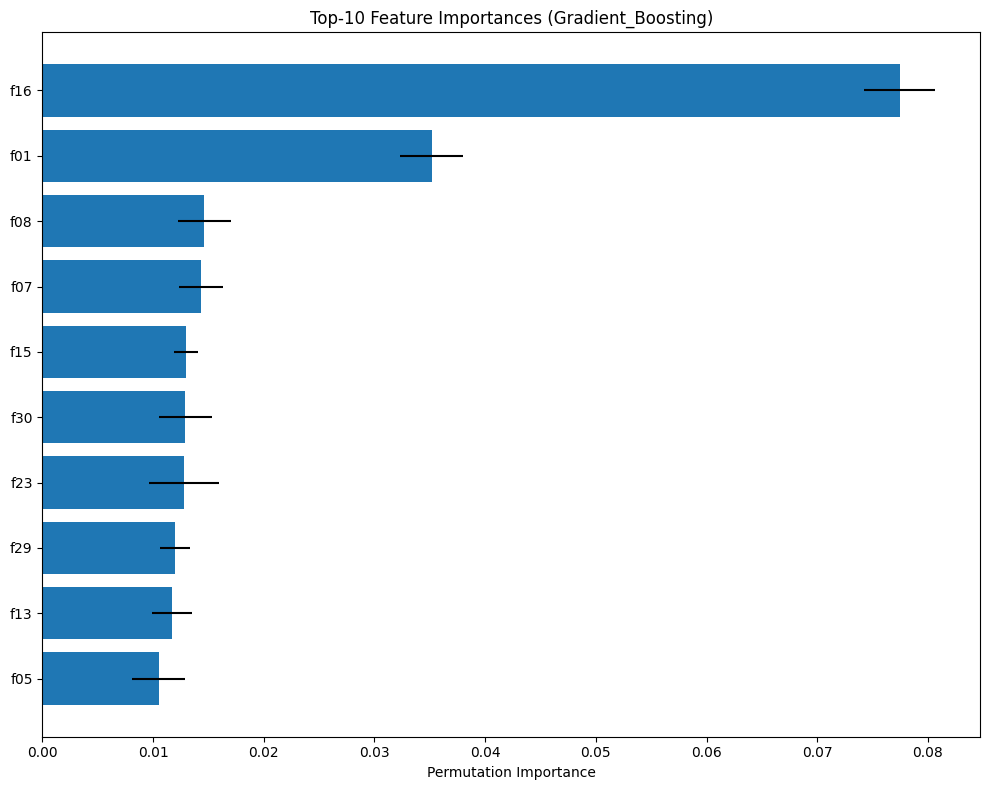

In [13]:
# Определяем лучшую модель (например, по ROC-AUC для бинарной или F1 для мультикласса)
if len(np.unique(y)) == 2:
    best_model_key = max(models_results.keys(), key=lambda x: models_results[x]['roc_auc'] if models_results[x]['roc_auc'] is not None else -float('inf'))
else:
    best_model_key = max(models_results.keys(), key=lambda x: models_results[x]['f1_score'])

best_model = all_models[best_model_key][0]
print(f"Лучшая модель: {best_model_key}")

# Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

# Получаем топ-10 признаков
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

top_features = importance_df.head(10)
print("\nТоп-10 наиболее важных признаков:")
print(top_features)

# Визуализация permutation importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance_mean'], xerr=top_features['importance_std'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title(f'Top-10 Feature Importances ({best_model_key})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('artifacts/figures/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.4. Сохранение артефактов

In [22]:
# Сохраняем метрики на тесте
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump({k: {metric: float(v) if isinstance(v, (np.float64, np.float32)) else v for metric, v in v.items()} for k, v in models_results.items()}, f, indent=2)

# Сохраняем результаты подбора гиперпараметров
search_summaries = {
    'Decision_Tree': {
        'best_params': dt_grid.best_params_,
        'cv_score': float(dt_grid.best_score_),
        'model_type': 'DecisionTree'
    },
    'Random_Forest': {
        'best_params': rf_grid.best_params_,
        'cv_score': float(rf_grid.best_score_),
        'model_type': 'RandomForest'
    },
    'Gradient_Boosting': {
        'best_params': gb_grid.best_params_,
        'cv_score': float(gb_grid.best_score_),
        'model_type': 'GradientBoosting'
    }
}
print(search_summaries)
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

# Сохраняем лучшую модель
joblib.dump(all_models[best_model_key][0], 'artifacts/best_model.joblib')

print(best_model_key)
# Сохраняем метаданные лучшей модели
best_model_meta = {
    'model_name': best_model_key,
    'model_type': str(type(all_models[best_model_key][0])),
    'test_metrics': {
        'accuracy': float(models_results[best_model_key]['accuracy']),
        'f1_score': float(models_results[best_model_key]['f1_score']),
        'roc_auc': float(models_results[best_model_key]['roc_auc']) if models_results[best_model_key]['roc_auc'] is not None else None
    },
}

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=2)

print("Артефакты сохранены успешно!")

{'Decision_Tree': {'best_params': {'max_depth': 10, 'min_samples_leaf': 20}, 'cv_score': 0.8333456973369888, 'model_type': 'DecisionTree'}, 'Random_Forest': {'best_params': {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}, 'cv_score': 0.9244251527465938, 'model_type': 'RandomForest'}, 'Gradient_Boosting': {'best_params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}, 'cv_score': 0.9239958437336078, 'model_type': 'GradientBoosting'}}
Gradient_Boosting
Артефакты сохранены успешно!
